In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# File paths
base_path = "/kaggle/input/store-sales-time-series-forecasting/"

# Load datasets (with engine="python" for large/complex CSVs)
oil_df = pd.read_csv(base_path + "oil.csv")
sample_submission_df = pd.read_csv(base_path + "sample_submission.csv")
holidays_events_df = pd.read_csv(base_path + "holidays_events.csv")
stores_df = pd.read_csv(base_path + "stores.csv")
train_df = pd.read_csv(base_path + "train.csv", engine="python")
test_df = pd.read_csv(base_path + "test.csv", engine="python")
transactions_df = pd.read_csv(base_path + "transactions.csv")

# Check basic info
print("oil:", oil_df.shape)
print("sample_submission:", sample_submission_df.shape)
print("holidays_events:", holidays_events_df.shape)
print("stores:", stores_df.shape)
print("train:", train_df.shape)
print("test:", test_df.shape)
print("transactions:", transactions_df.shape)


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/store-sales-time-series-forecasting/oil.csv'

EDA

In [ ]:
oil_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [ ]:
oil_df.tail()


,date,dcoilwtico
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96
1217,2017-08-31,47.26


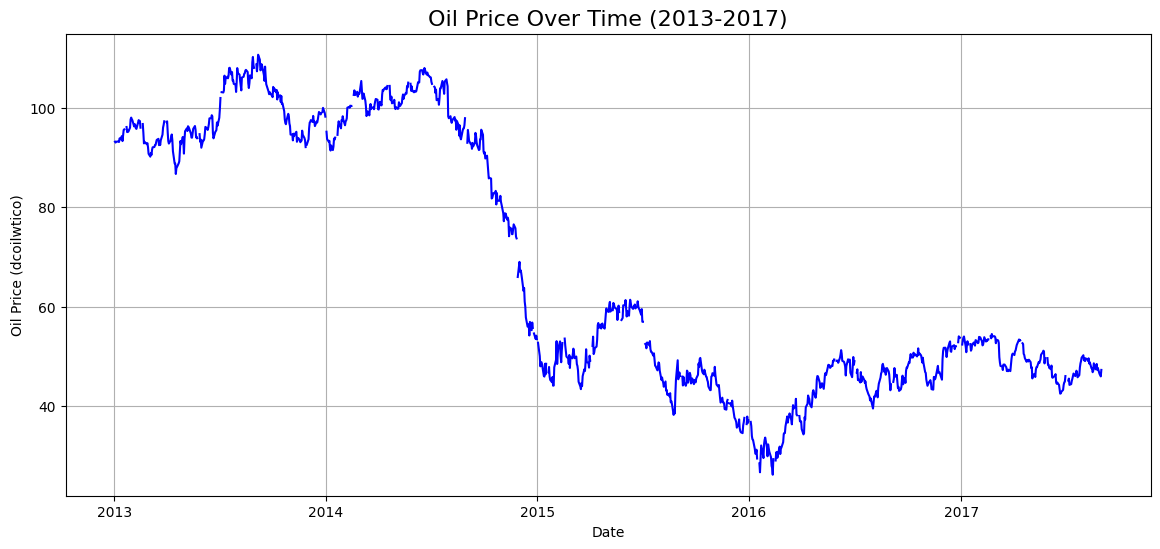

In [ ]:


# Convert date column to datetime if not already
oil_df['date'] = pd.to_datetime(oil_df['date'])

# Set date as index
oil_df.set_index('date', inplace=True)

# Plot oil price over time
plt.figure(figsize=(14,6))
plt.plot(oil_df.index, oil_df['dcoilwtico'], color="blue")
plt.title("Oil Price Over Time (2013-2017)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Oil Price (dcoilwtico)")
plt.grid(True)
plt.show()

/tmp/ipykernel_36/1489400189.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = oil_df['dcoilwtico'].resample('M').mean()


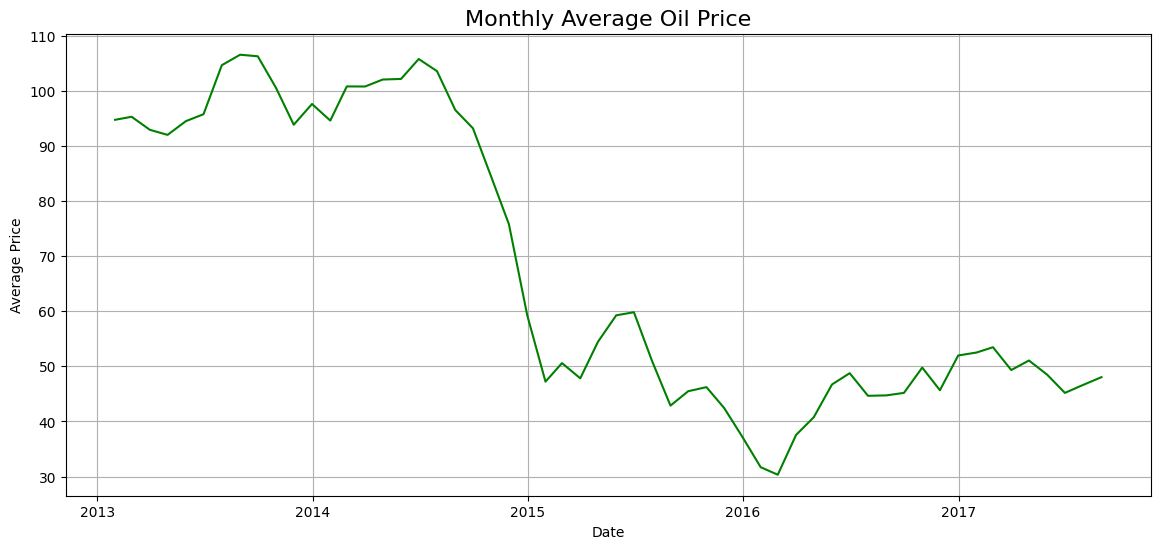

In [ ]:
# Resample to monthly average
monthly_avg = oil_df['dcoilwtico'].resample('M').mean()

plt.figure(figsize=(14,6))
plt.plot(monthly_avg.index, monthly_avg, color="green")
plt.title("Monthly Average Oil Price", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.grid(True)
plt.show()

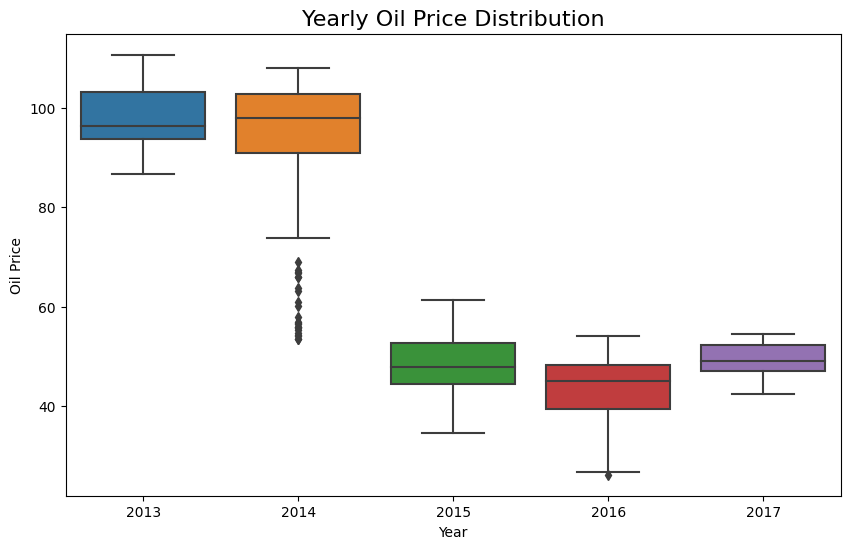

In [ ]:
# Yearly distribution using boxplot
oil_df['year'] = oil_df.index.year
plt.figure(figsize=(10,6))
sns.boxplot(x='year', y='dcoilwtico', data=oil_df.reset_index())
plt.title("Yearly Oil Price Distribution", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Oil Price")
plt.show()

looks like 2014 has outliers maybe something happened on 2014

In [ ]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
train_df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [ ]:
# Make sure 'date' is datetime
train_df['date'] = pd.to_datetime(train_df['date'])

# Group by date and sum sales
daily_sales_df = train_df.groupby('date', as_index=False)['sales'].sum()

# Rename for clarity
daily_sales_df.rename(columns={'sales': 'sum_sales'}, inplace=True)

# Preview
daily_sales_df.head()


,date,sum_sales
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229


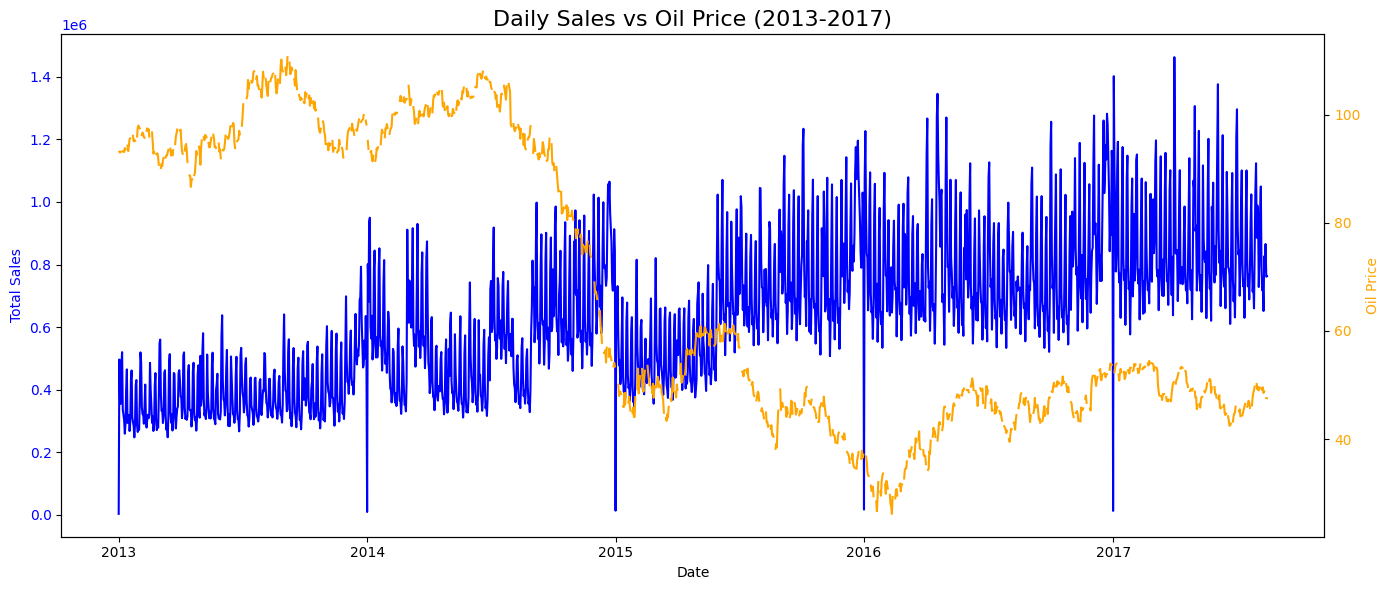

In [ ]:
# import matplotlib.pyplot as plt

# Merge sales and oil price on date
merged_df = daily_sales_df.merge(oil_df[['dcoilwtico']], 
                                 left_on='date', right_index=True, how='left')

# Plot
fig, ax1 = plt.subplots(figsize=(14,6))

# Sales on left y-axis
ax1.plot(merged_df['date'], merged_df['sum_sales'], color="blue", label="Daily Sales")
ax1.set_xlabel("Date")
ax1.set_ylabel("Total Sales", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Oil price on right y-axis
ax2 = ax1.twinx()
ax2.plot(merged_df['date'], merged_df['dcoilwtico'], color="orange", label="Oil Price")
ax2.set_ylabel("Oil Price", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

# Title
plt.title("Daily Sales vs Oil Price (2013-2017)", fontsize=16)

# Show legend
fig.tight_layout()
plt.show()


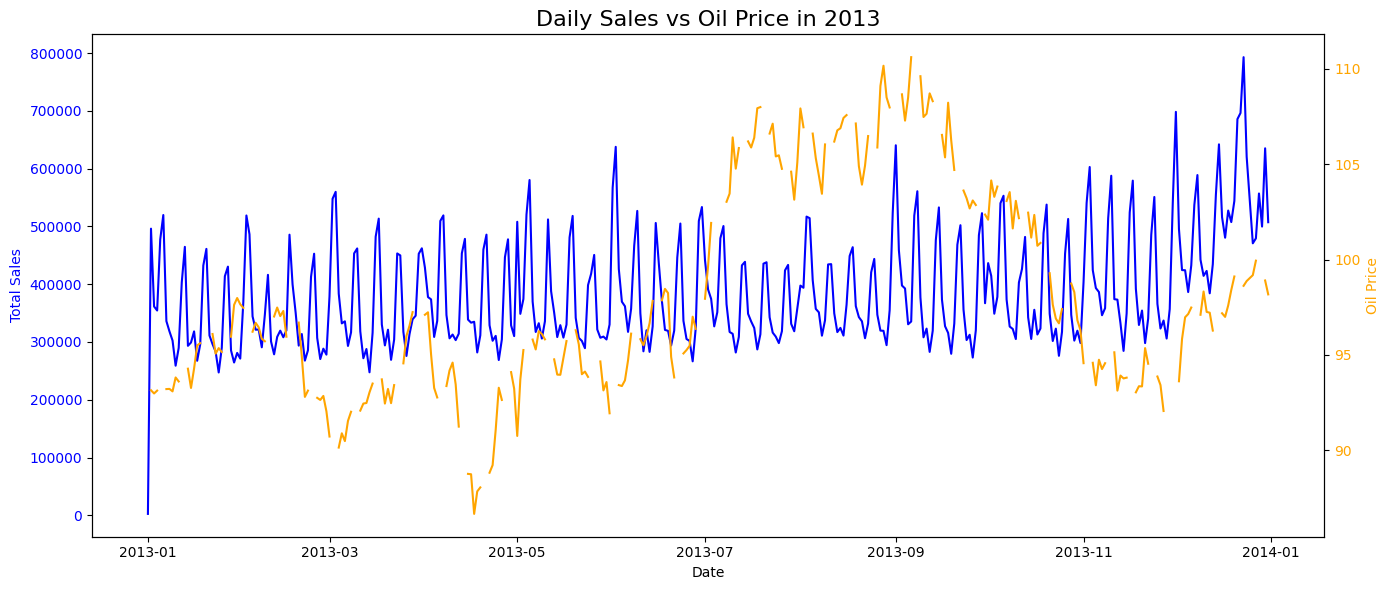

In [ ]:
import matplotlib.pyplot as plt

# Filter for 2013
sales_2013 = daily_sales_df[(daily_sales_df['date'].dt.year == 2013)]
oil_2013 = oil_df[(oil_df.index.year == 2013)]

# Merge on date
merged_2013 = sales_2013.merge(oil_2013[['dcoilwtico']], 
                               left_on='date', right_index=True, how='left')

# Plot
fig, ax1 = plt.subplots(figsize=(14,6))

# Sales on left y-axis
ax1.plot(merged_2013['date'], merged_2013['sum_sales'], color="blue", label="Daily Sales")
ax1.set_xlabel("Date")
ax1.set_ylabel("Total Sales", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Oil price on right y-axis
ax2 = ax1.twinx()
ax2.plot(merged_2013['date'], merged_2013['dcoilwtico'], color="orange", label="Oil Price")
ax2.set_ylabel("Oil Price", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

plt.title("Daily Sales vs Oil Price in 2013", fontsize=16)
fig.tight_layout()
plt.show()


always a drop at the beginning of the year for all years

In [ ]:
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [ ]:
# Merge train_df with stores_df to get cluster for each store
train_cluster_df = train_df.merge(stores_df[['store_nbr', 'cluster']], on='store_nbr', how='left')

# Make sure 'date' is datetime
train_cluster_df['date'] = pd.to_datetime(train_cluster_df['date'])

# Extract month and year
train_cluster_df['year'] = train_cluster_df['date'].dt.year
train_cluster_df['month'] = train_cluster_df['date'].dt.month


In [ ]:
# Aggregate sales by cluster, year, month
cluster_monthly_sales = train_cluster_df.groupby(
    ['cluster', 'year', 'month'], as_index=False)['sales'].sum()
cluster_monthly_sales.rename(columns={'sales': 'total_sales'}, inplace=True)

# Preview
cluster_monthly_sales.head()


,cluster,year,month,total_sales
0,1,2013,1,583506.305028
1,1,2013,2,622716.878992
2,1,2013,3,707423.551954
3,1,2013,4,605589.910928
4,1,2013,5,633333.905892


In [ ]:
# For each year-month, find cluster with max sales
best_cluster_per_month = cluster_monthly_sales.loc[
    cluster_monthly_sales.groupby(['year','month'])['total_sales'].idxmax()
]

best_cluster_per_month.reset_index(drop=True, inplace=True)
best_cluster_per_month.head()


,cluster,year,month,total_sales
0,14,2013,1,1.752318e+06
1,14,2013,2,1.617893e+06
2,14,2013,3,1.932583e+06
3,14,2013,4,1.773148e+06
4,14,2013,5,1.822926e+06


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


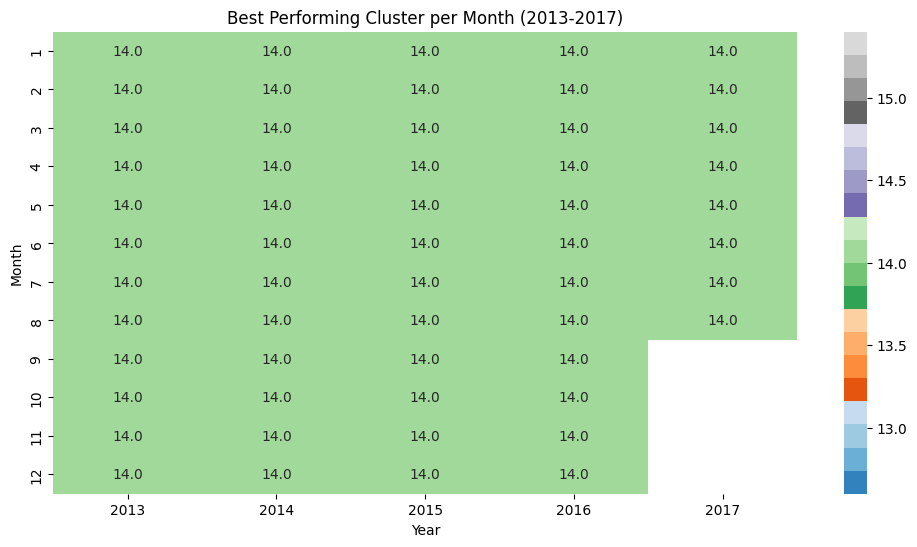

In [ ]:
# Pivot to create heatmap of best cluster per month
heatmap_best = best_cluster_per_month.pivot(
    index="month",   # y-axis
    columns="year",  # x-axis
    values="cluster" # values to show
)

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_best, annot=True, fmt="", cmap="tab20c")
plt.title("Best Performing Cluster per Month (2013-2017)")
plt.xlabel("Year")
plt.ylabel("Month")
plt.show()


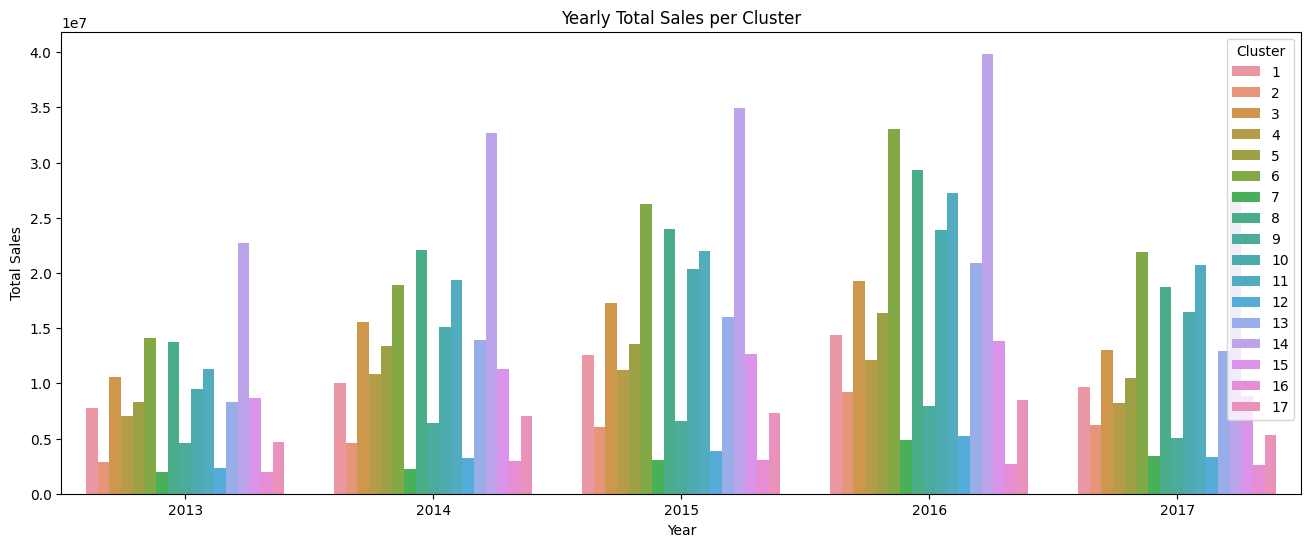

In [ ]:
yearly_sales = cluster_monthly_sales.groupby(['year','cluster'], as_index=False)['total_sales'].sum()

plt.figure(figsize=(16,6))
sns.barplot(data=yearly_sales, x='year', y='total_sales', hue='cluster')
plt.title("Yearly Total Sales per Cluster")
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.legend(title="Cluster")
plt.show()


Cluster 14 performed best every year

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

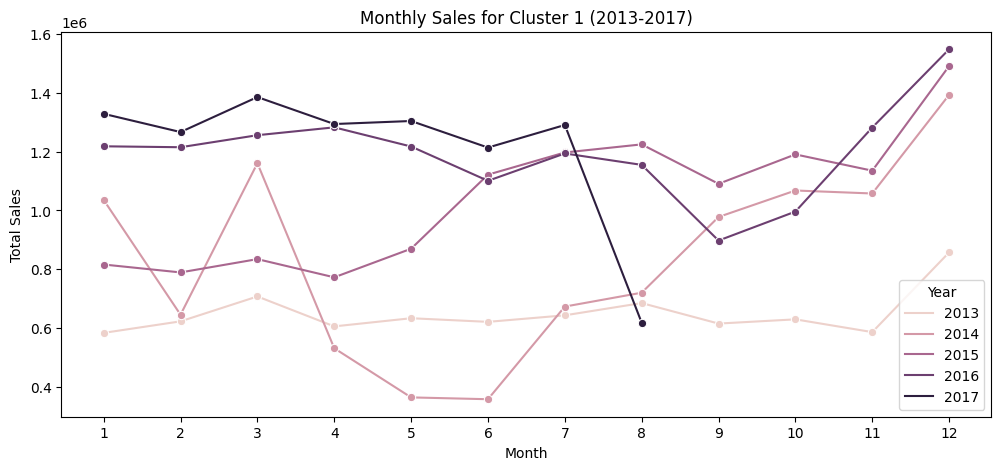

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

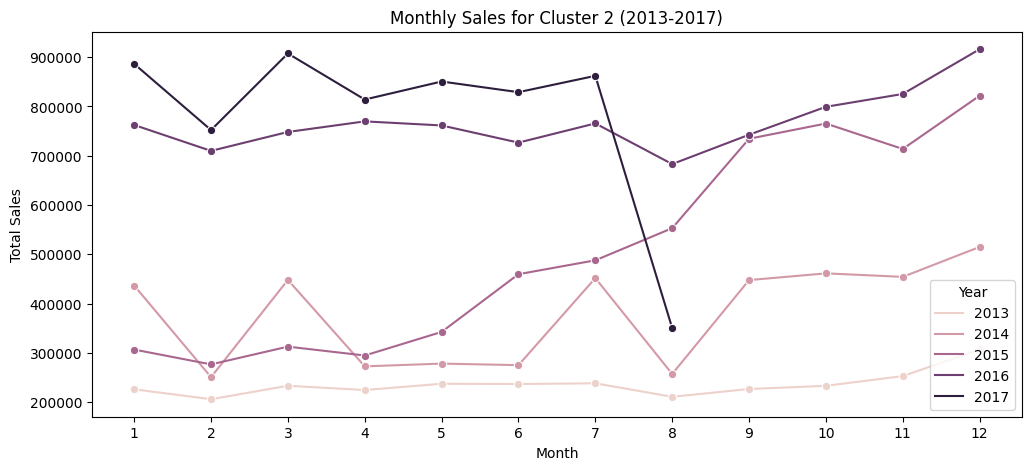

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

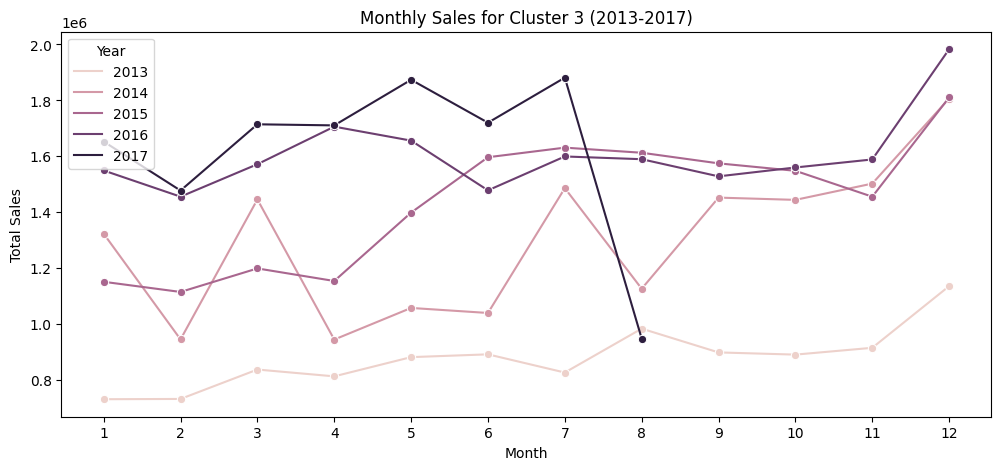

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

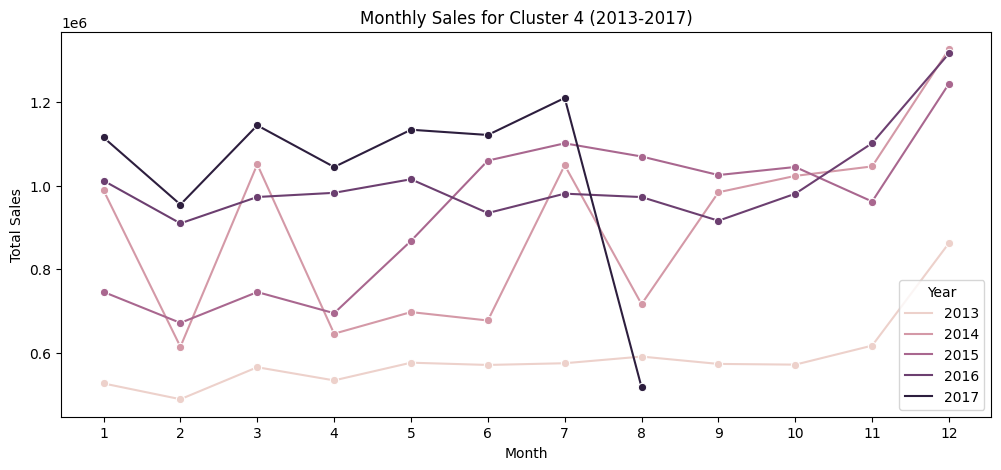

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

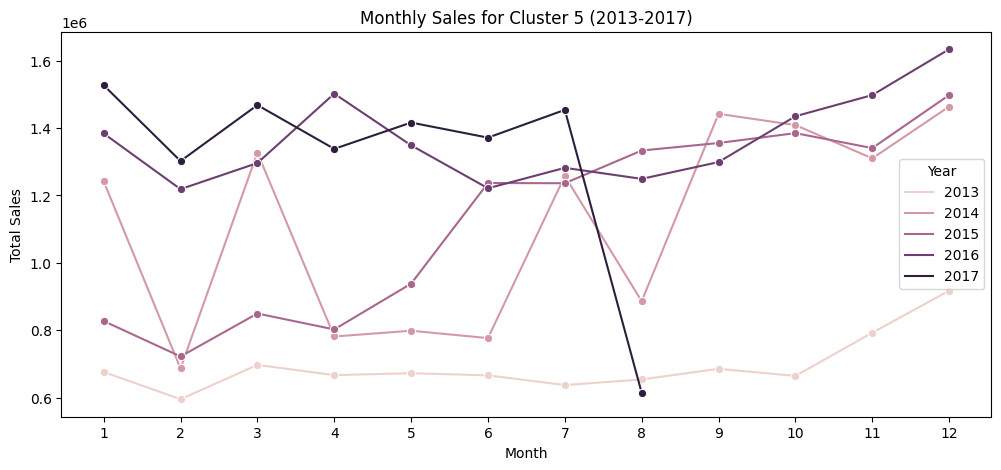

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

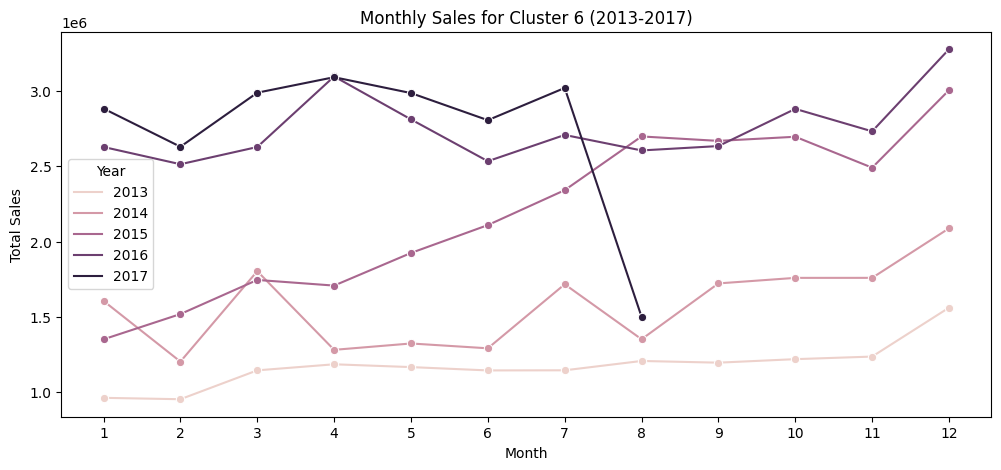

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

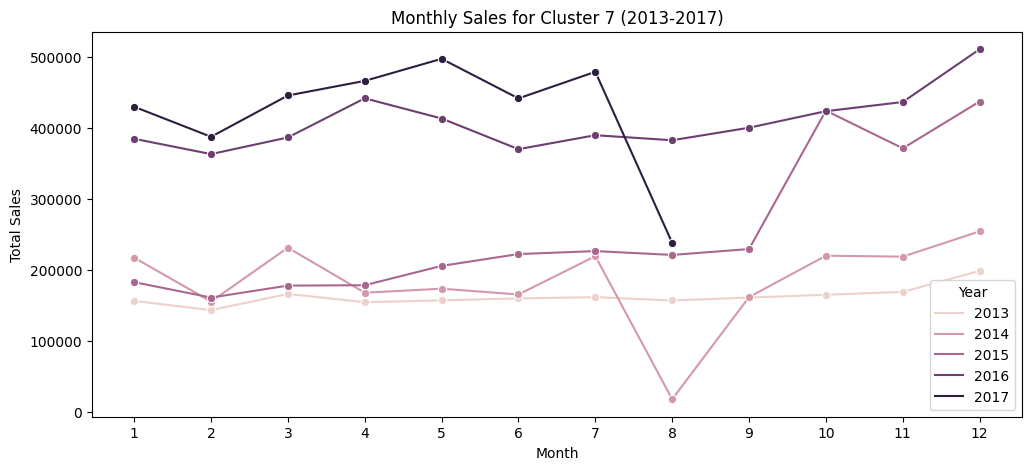

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

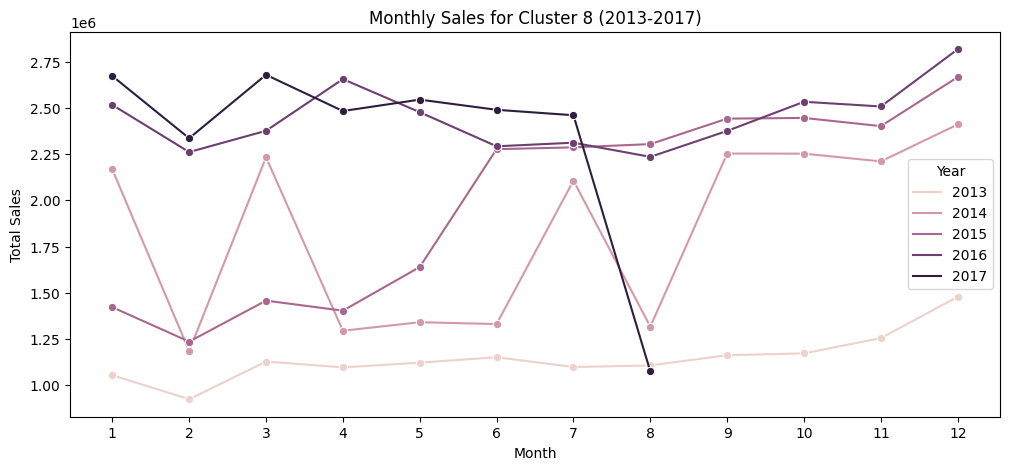

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

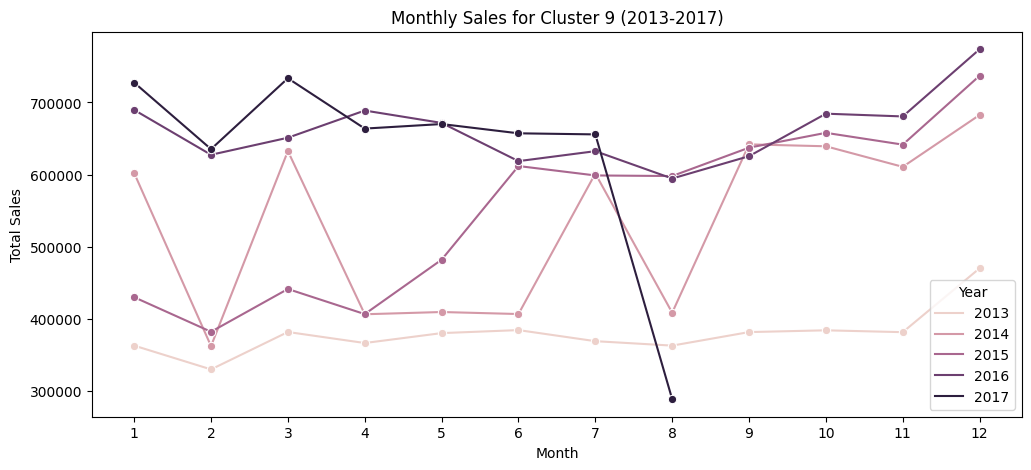

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

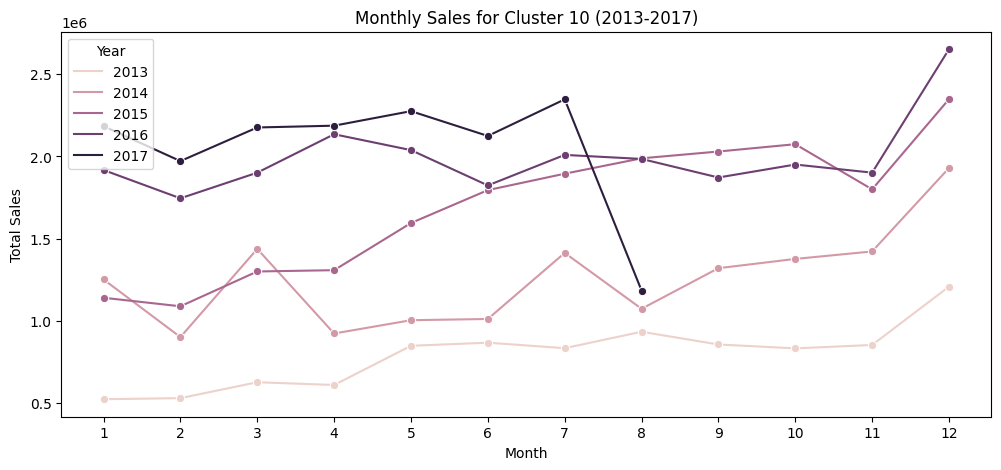

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

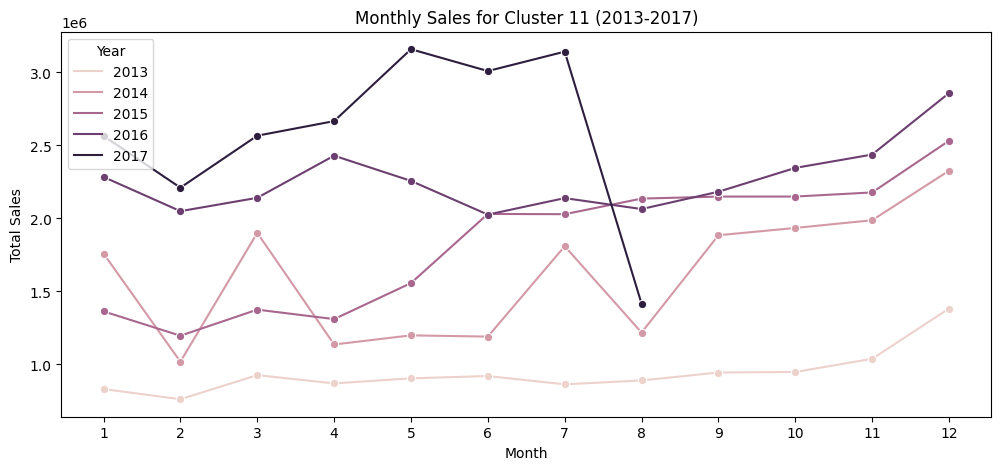

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

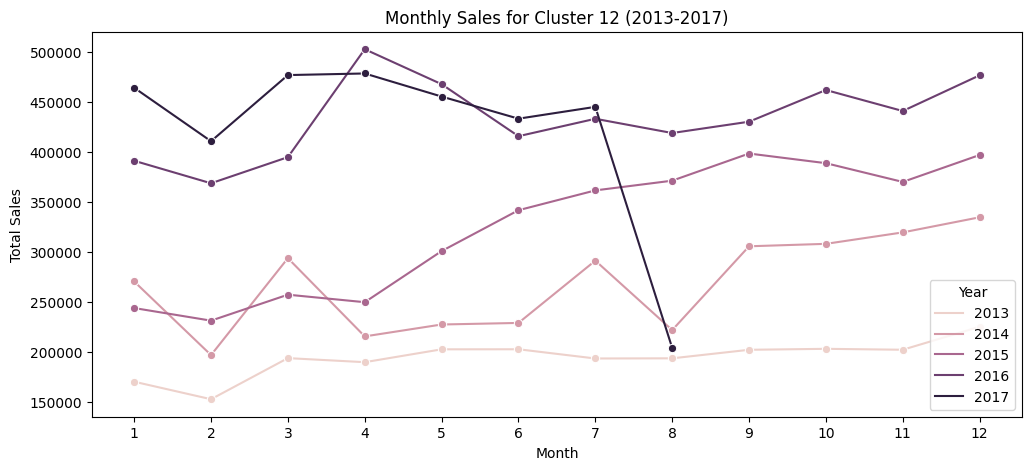

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

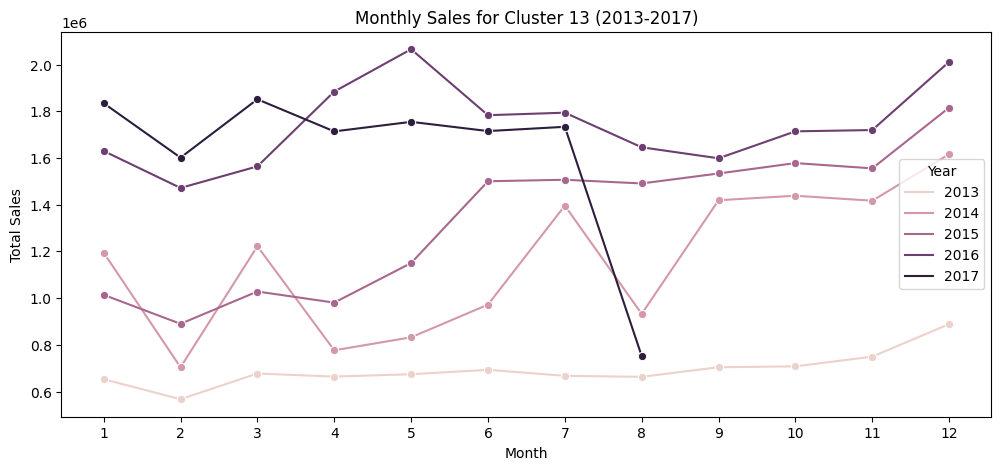

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

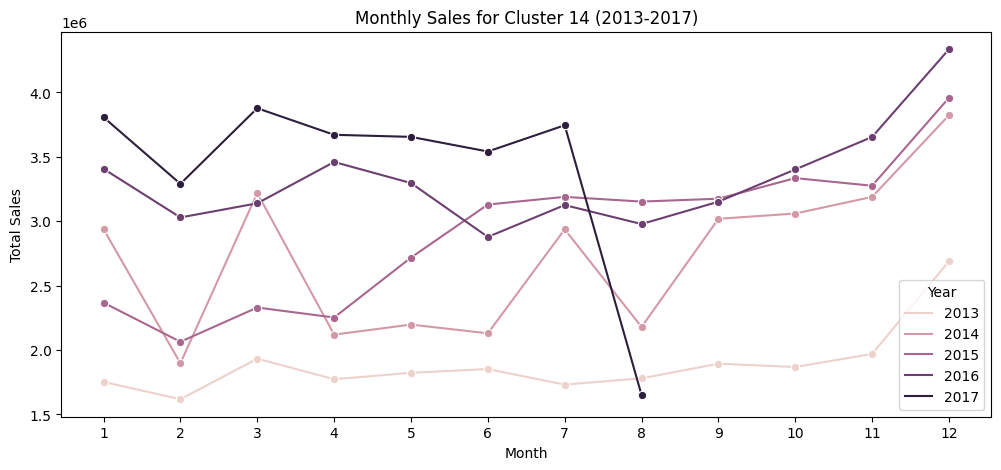

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

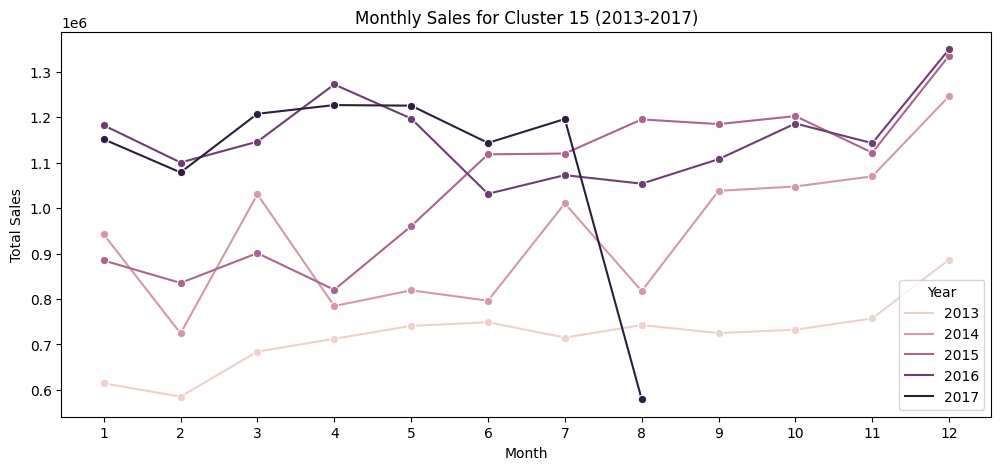

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

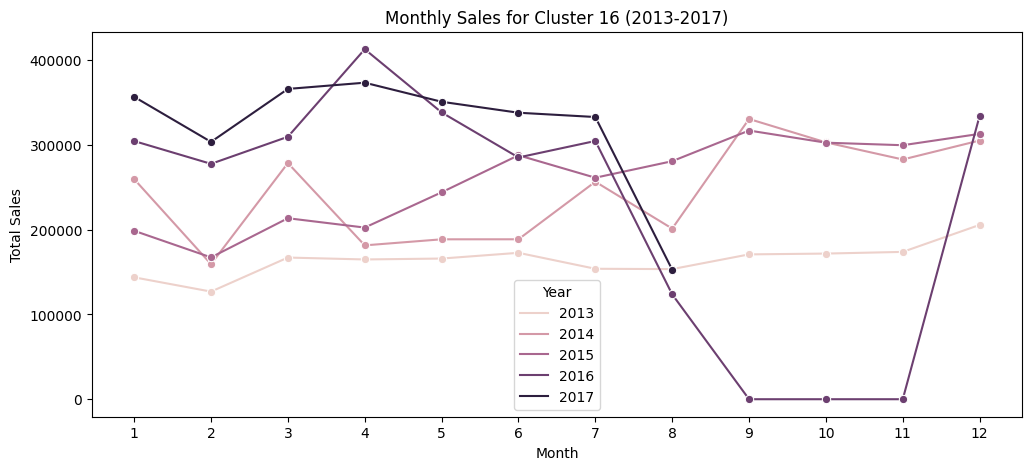

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

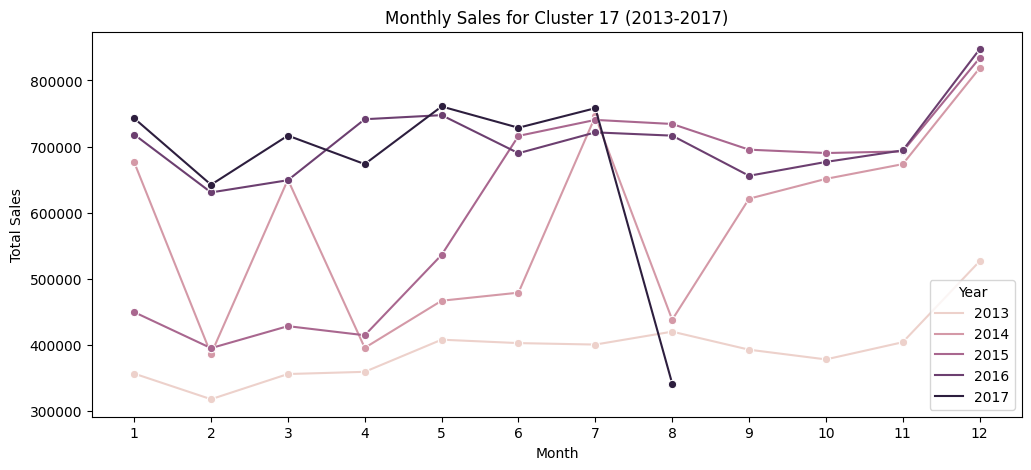

In [ ]:
# Get unique clusters
clusters = cluster_monthly_sales['cluster'].unique()

# Plot for each cluster
for cluster in clusters:
    cluster_data = cluster_monthly_sales[cluster_monthly_sales['cluster'] == cluster]
    
    plt.figure(figsize=(12,5))
    sns.lineplot(data=cluster_data, x='month', y='total_sales', hue='year', marker="o")
    
    plt.title(f"Monthly Sales for Cluster {cluster} (2013-2017)")
    plt.xlabel("Month")
    plt.ylabel("Total Sales")
    plt.xticks(range(1,13))
    plt.legend(title="Year")
    plt.show()


something happened on 2017-08 as every cluster sales saw a drop

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

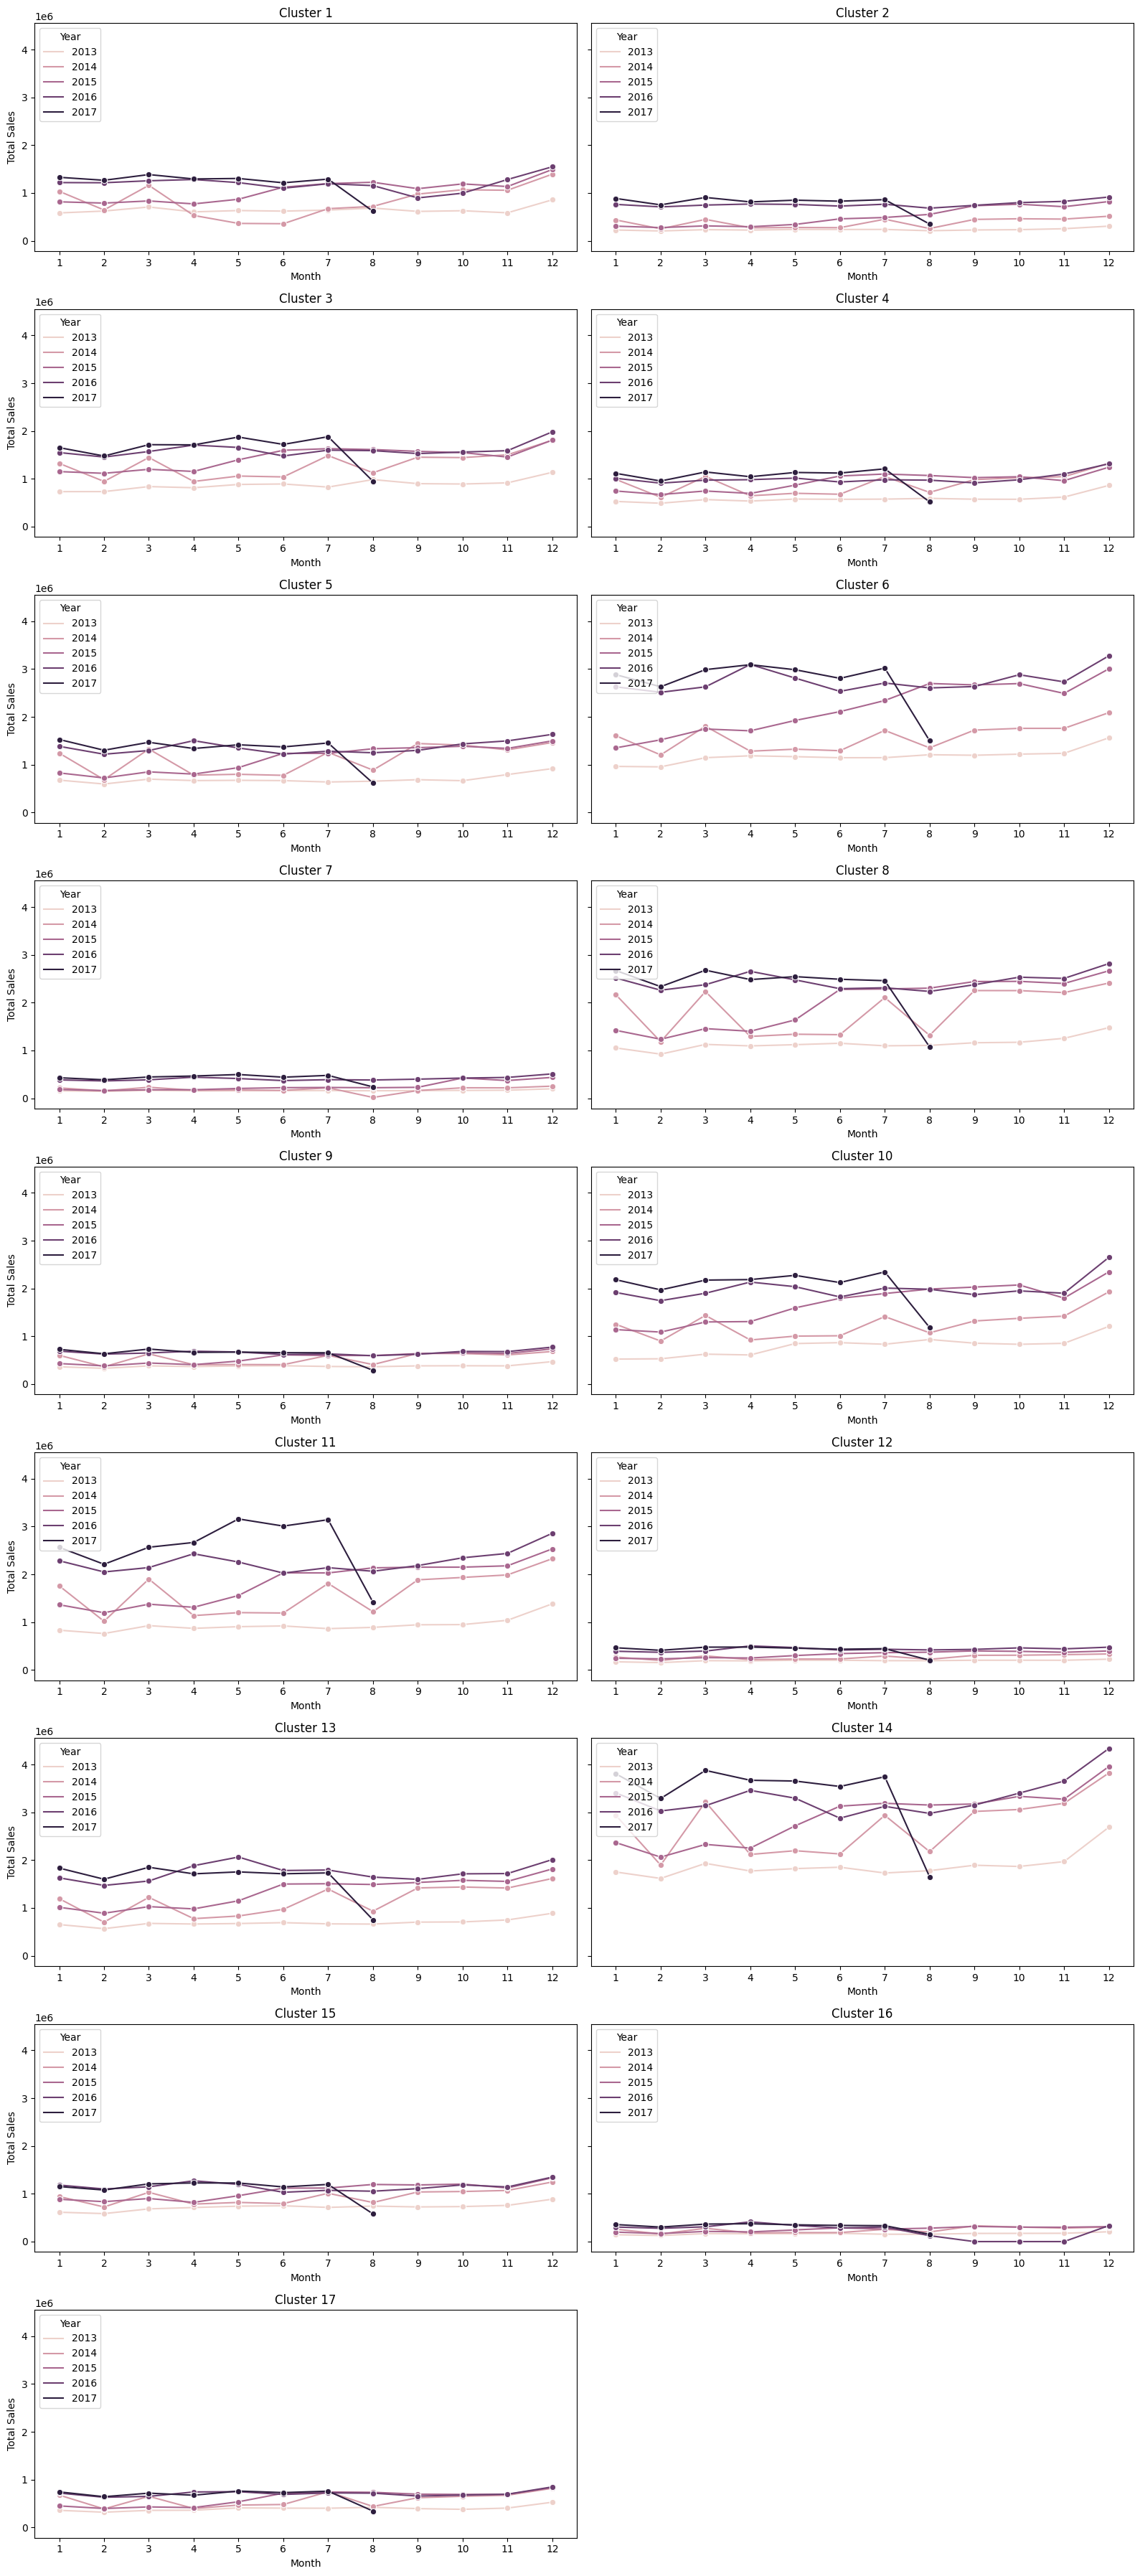

In [ ]:
# Get unique clusters
clusters = cluster_monthly_sales['cluster'].unique()
n_clusters = len(clusters)

# Define subplot grid (adjust rows/cols as needed)
n_cols = 2
n_rows = (n_clusters + 1) // n_cols  # ensures all clusters fit

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*4), sharey=True)
axes = axes.flatten()  # flatten to 1D array for easy indexing

for i, cluster in enumerate(clusters):
    cluster_data = cluster_monthly_sales[cluster_monthly_sales['cluster'] == cluster]
    sns.lineplot(
        data=cluster_data,
        x='month',
        y='total_sales',
        hue='year',
        marker="o",
        ax=axes[i]
    )
    axes[i].set_title(f"Cluster {cluster}")
    axes[i].set_xlabel("Month")
    axes[i].set_ylabel("Total Sales")
    axes[i].set_xticks(range(1,13))
    axes[i].legend(title="Year", loc='upper left')

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


rise in sales fro months following 2016-04 because of earth quake in all clusters

In [ ]:
holidays_events_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [ ]:
# Make sure 'date' is datetime
holidays_events_df['date'] = pd.to_datetime(holidays_events_df['date'])

# Filter for August 2017
holidays_aug_2017 = holidays_events_df[
    (holidays_events_df['date'].dt.year == 2017) &
    (holidays_events_df['date'].dt.month == 8)
]

# Display the result
holidays_aug_2017


,date,type,locale,locale_name,description,transferred
323,2017-08-05,Holiday,Local,Esmeraldas,Fundacion de Esmeraldas,False
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
325,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
326,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False
327,2017-08-24,Holiday,Local,Ambato,Fundacion de Ambato,False


In [ ]:
# Copy daily_sales_df for 2013-2017
sales_df = daily_sales_df.copy()

# Create a column indicating if the day is a payday
sales_df['payday'] = sales_df['date'].dt.day.isin([15, sales_df['date'].dt.days_in_month])


In [ ]:
payday_sales = sales_df.groupby('payday')['sum_sales'].mean().reset_index()
payday_sales


,payday,sum_sales
0,False,638110.453743
1,True,621448.812671


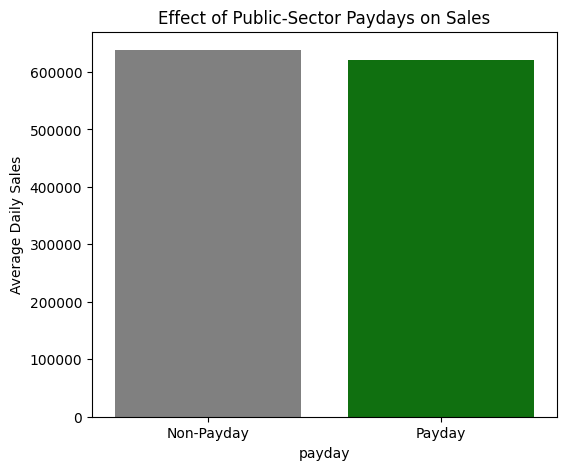

In [ ]:
plt.figure(figsize=(6,5))
sns.barplot(data=payday_sales, x='payday', y='sum_sales', palette=['gray','green'])
plt.xticks([0,1], ['Non-Payday','Payday'])
plt.ylabel("Average Daily Sales")
plt.title("Effect of Public-Sector Paydays on Sales")
plt.show()


In [ ]:
# Copy daily_sales_df
sales_df = daily_sales_df.copy()

# Payday = 15th or last day of the month
sales_df['payday'] = sales_df['date'].dt.day.isin([15, sales_df['date'].dt.days_in_month])

# Label for clarity
sales_df['day_type'] = sales_df['payday'].map({True: 'Payday', False: 'Rest of Month'})


In [ ]:
day_type_sales = sales_df.groupby('day_type')['sum_sales'].mean().reset_index()
day_type_sales


,day_type,sum_sales
0,Payday,621448.812671
1,Rest of Month,638110.453743


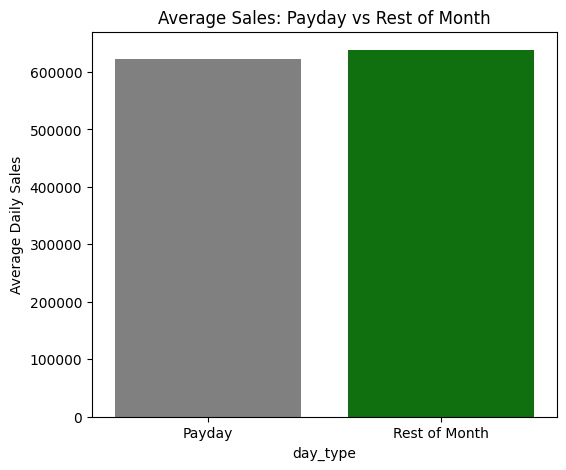

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.barplot(data=day_type_sales, x='day_type', y='sum_sales', palette=['gray','green'])
plt.ylabel("Average Daily Sales")
plt.title("Average Sales: Payday vs Rest of Month")
plt.show()


In [ ]:
# Copy daily_sales_df
sales_df = daily_sales_df.copy()

# Extract day of month
sales_df['day_of_month'] = sales_df['date'].dt.day

# Mark paydays (15th and last day of month)
sales_df['last_day_of_month'] = sales_df['date'].dt.days_in_month
sales_df['payday'] = sales_df['day_of_month'].isin([15]) | (sales_df['day_of_month'] == sales_df['last_day_of_month'])


In [ ]:
# Average sales for each day of the month across all months and years
daily_avg_sales = sales_df.groupby('day_of_month')['sum_sales'].mean().reset_index()


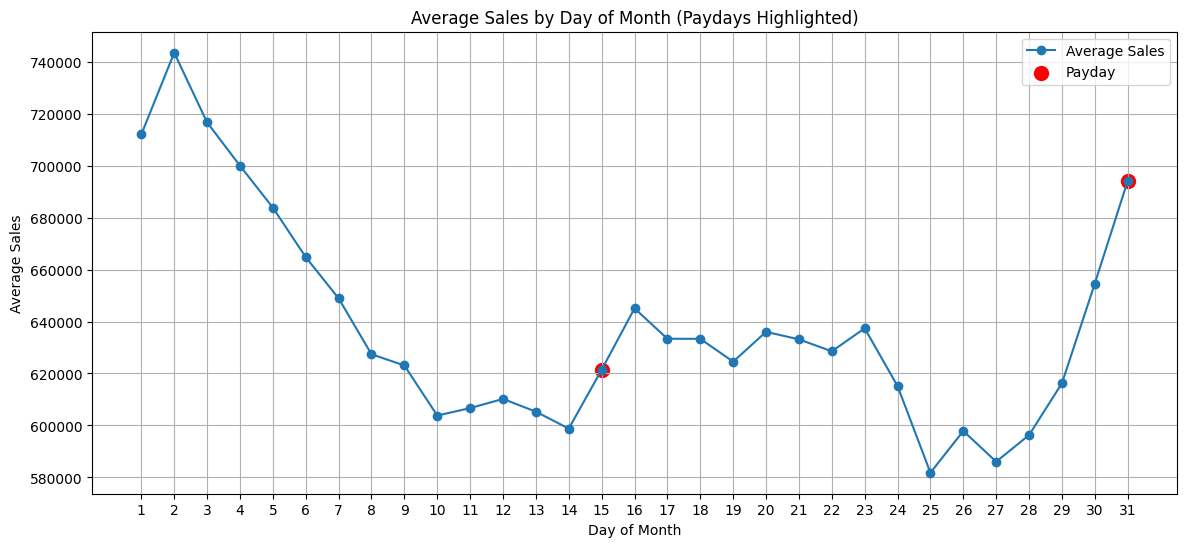

In [ ]:
plt.figure(figsize=(14,6))

# Line for average sales
plt.plot(daily_avg_sales['day_of_month'], daily_avg_sales['sum_sales'], marker='o', label='Average Sales')

# Highlight paydays
paydays = [15, 31]  # 15th and last day of month (approx)
plt.scatter(paydays, daily_avg_sales[daily_avg_sales['day_of_month'].isin(paydays)]['sum_sales'],
            color='red', s=100, label='Payday')

plt.xticks(range(1,32))
plt.xlabel("Day of Month")
plt.ylabel("Average Sales")
plt.title("Average Sales by Day of Month (Paydays Highlighted)")
plt.grid(True)
plt.legend()
plt.show()


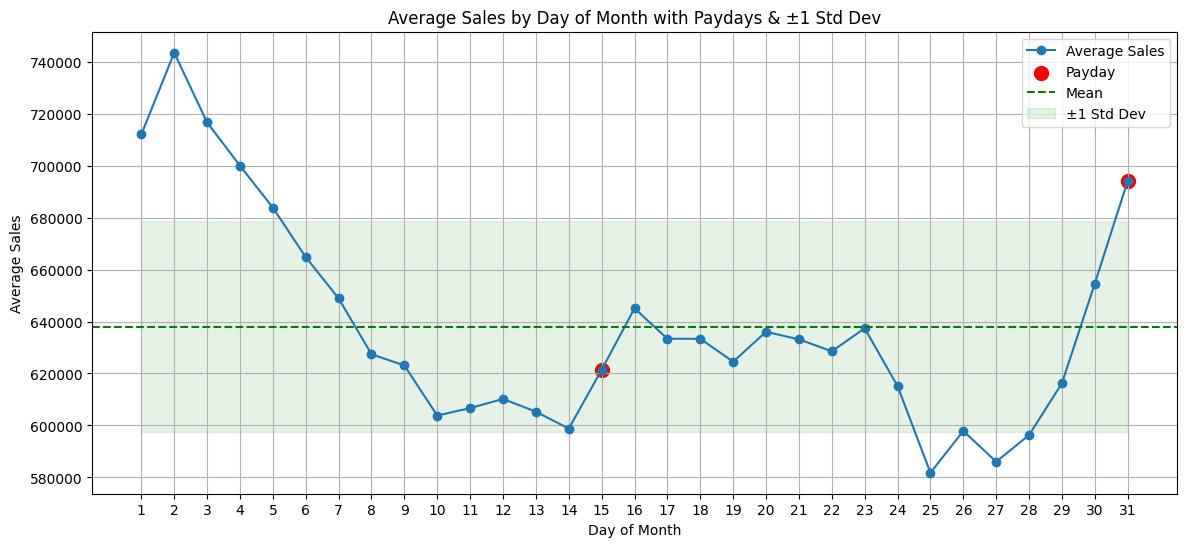

In [ ]:
plt.figure(figsize=(14,6))

# Line for average sales
plt.plot(daily_avg_sales['day_of_month'], daily_avg_sales['sum_sales'], marker='o', label='Average Sales')

# Highlight paydays
paydays = [15, 31]  # 15th and last day of month (approx)
plt.scatter(
    paydays, 
    daily_avg_sales[daily_avg_sales['day_of_month'].isin(paydays)]['sum_sales'],
    color='red', s=100, label='Payday'
)

# Mean and std
mean_sales = daily_avg_sales['sum_sales'].mean()
std_sales = daily_avg_sales['sum_sales'].std()

# Plot mean line
plt.axhline(mean_sales, color='green', linestyle='--', label='Mean')

# Shade ±3 std region
plt.fill_between(
    daily_avg_sales['day_of_month'], 
    mean_sales - 1*std_sales, 
    mean_sales + 1*std_sales, 
    color='green', alpha=0.1, label='±1 Std Dev'
)

plt.xticks(range(1,32))
plt.xlabel("Day of Month")
plt.ylabel("Average Sales")
plt.title("Average Sales by Day of Month with Paydays & ±1 Std Dev")
plt.grid(True)
plt.legend()
plt.show()


looks like there is an increase on sales during and around paydays, looks like a 3 day window with pay day in the middle and one day and one day after